In [1]:
import librosa
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [3]:
def extract_features(file_path):

    y,sr = librosa.load(file_path, sr=None)
    features = np.array([])

    # Extract MFCC
    mfccs = np.mean(librosa.feature.mfcc(y=y,sr=sr, n_mfcc=13).T, axis=0)
    features = np.hstack((features,mfccs))

    # Extract chromagram
    stft = np.abs(librosa.stft(y))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    features = np.hstack((features,chroma))


    #Extract Mel-scaled  spectogram
    mel = np.mean(librosa.feature.melspectrogram(y=y,sr=sr).T,axis=0)
    features = np.hstack((features,mel))

    #Extract spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T, axis=0)
    features = np.hstack((features,contrast))

    # Extract tonnetz (tonal centroid)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y),sr=sr).T, axis=0)
    features = np.hstack((features,tonnetz))

    return features

dataset_path = 'speech-emotion-recognition-ravdess-data/'
features = []
labels = []
  

for actor_folder in os.listdir(dataset_path):
    actor_path = os.path.join(dataset_path, actor_folder)

    if not os.path.isdir(actor_path):
        continue
    
    # Loop over each .wav file in the actor's folder
    for file_name in os.listdir(actor_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(actor_path, file_name)
            feature_vector = extract_features(file_path)
            emotion_label = int(file_name.split('-')[2])
            features.append(feature_vector)
            labels.append(emotion_label)

X = np.array(features)
y = np.array(labels)


print(f"Shape of feature array: {X.shape}")
print(f"Shape of label array: {y.shape}")

Shape of feature array: (1440, 166)
Shape of label array: (1440,)


In [4]:
print(X)
print(y)

[[-4.19084900e+02  2.58726368e+01 -2.53285732e+01 ... -1.25231915e-02
   1.37319841e-02 -2.37145104e-03]
 [-4.62970459e+02  4.07926025e+01 -1.24082699e+01 ... -7.24190637e-03
   1.42959884e-02  4.24624146e-03]
 [-5.04816345e+02  3.53618660e+01 -1.43495779e+01 ...  1.42827085e-02
   3.92680255e-03 -9.51682134e-03]
 ...
 [-5.28396057e+02  3.60580826e+01  1.05310860e+01 ... -3.27147422e-02
   4.24752856e-02 -3.70507225e-03]
 [-5.19508362e+02  4.95244560e+01 -1.54960556e+01 ...  2.10673333e-02
   2.32123278e-02 -2.46137303e-04]
 [-5.25628235e+02  4.01392059e+01  5.55322647e+00 ... -3.41360771e-03
   4.55950458e-02 -1.75802010e-02]]
[6 5 7 ... 7 4 7]


In [5]:
feature_columns = [f'mfcc_{i+1}' for i in range(13)] + \
                  [f'chroma_{i+1}' for i in range(12)] + \
                  [f'mel_{i+1}' for i in range(128)] + \
                  [f'contrast_{i+1}' for i in range(7)] + \
                  [f'tonnetz_{i+1}' for i in range(6)]

df = pd.DataFrame(X, columns=feature_columns)
df['label'] = y  

# Save the DataFrame to a CSV file
csv_file_path = 'speech_emotion_recognition_features.csv'
df.to_csv(csv_file_path, index=False)

In [6]:
import pandas as pd

# Load your dataset (assuming it's a CSV file)
df = pd.read_csv('speech_emotion_recognition_features.csv')

emotion_counts = df['label'].value_counts()
print("Sample counts for each emotion class:")
print(emotion_counts)

min_samples = emotion_counts.min()
print(f'Minimum samples per emotion class: {min_samples}')

balanced_df = df.groupby('label').apply(lambda x: x.sample(min_samples)).reset_index(drop=True)

print("\nBalanced dataset sample counts:")
print(balanced_df['label'].value_counts())

balanced_csv_file_path = '.speech_emotion_recognition_balanced.csv'
balanced_df.to_csv(balanced_csv_file_path, index=False)
print(f"Balanced dataset saved to {balanced_csv_file_path}")




Sample counts for each emotion class:
label
6    192
5    192
7    192
2    192
8    192
4    192
3    192
1     96
Name: count, dtype: int64
Minimum samples per emotion class: 96

Balanced dataset sample counts:
label
1    96
2    96
3    96
4    96
5    96
6    96
7    96
8    96
Name: count, dtype: int64
Balanced dataset saved to .speech_emotion_recognition_balanced.csv


/tmp/ipykernel_28927/2149774394.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('label').apply(lambda x: x.sample(min_samples)).reset_index(drop=True)


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your balanced dataset
balanced_df = pd.read_csv('speech_emotion_recognition_balanced.csv')

# Separate features and labels
X = balanced_df.drop(columns=['label'])  # Features (all columns except 'label')
y = balanced_df['label']                  # Labels (the 'label' column)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shapes of the resulting datasets
print(f"Shape of training features: {X_train.shape}")
print(f"Shape of training labels: {y_train.shape}")
print(f"Shape of testing features: {X_test.shape}")
print(f"Shape of testing labels: {y_test.shape}")


Shape of training features: (614, 166)
Shape of training labels: (614,)
Shape of testing features: (154, 166)
Shape of testing labels: (154,)


/tmp/ipykernel_28927/4007115576.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(X[:, start_idx:end_idx], labels=[f'{feature_name} {i+1}' for i in range(feature_dim)])
/tmp/ipykernel_28927/4007115576.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(X[:, start_idx:end_idx], labels=[f'{feature_name} {i+1}' for i in range(feature_dim)])
/tmp/ipykernel_28927/4007115576.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(X[:, start_idx:end_idx], labels=[f'{feature_name} {i+1}' for i in range(feature_dim)])
/tmp/ipykernel_28927/4007115576.py:30: MatplotlibDeprecationWarning: The 

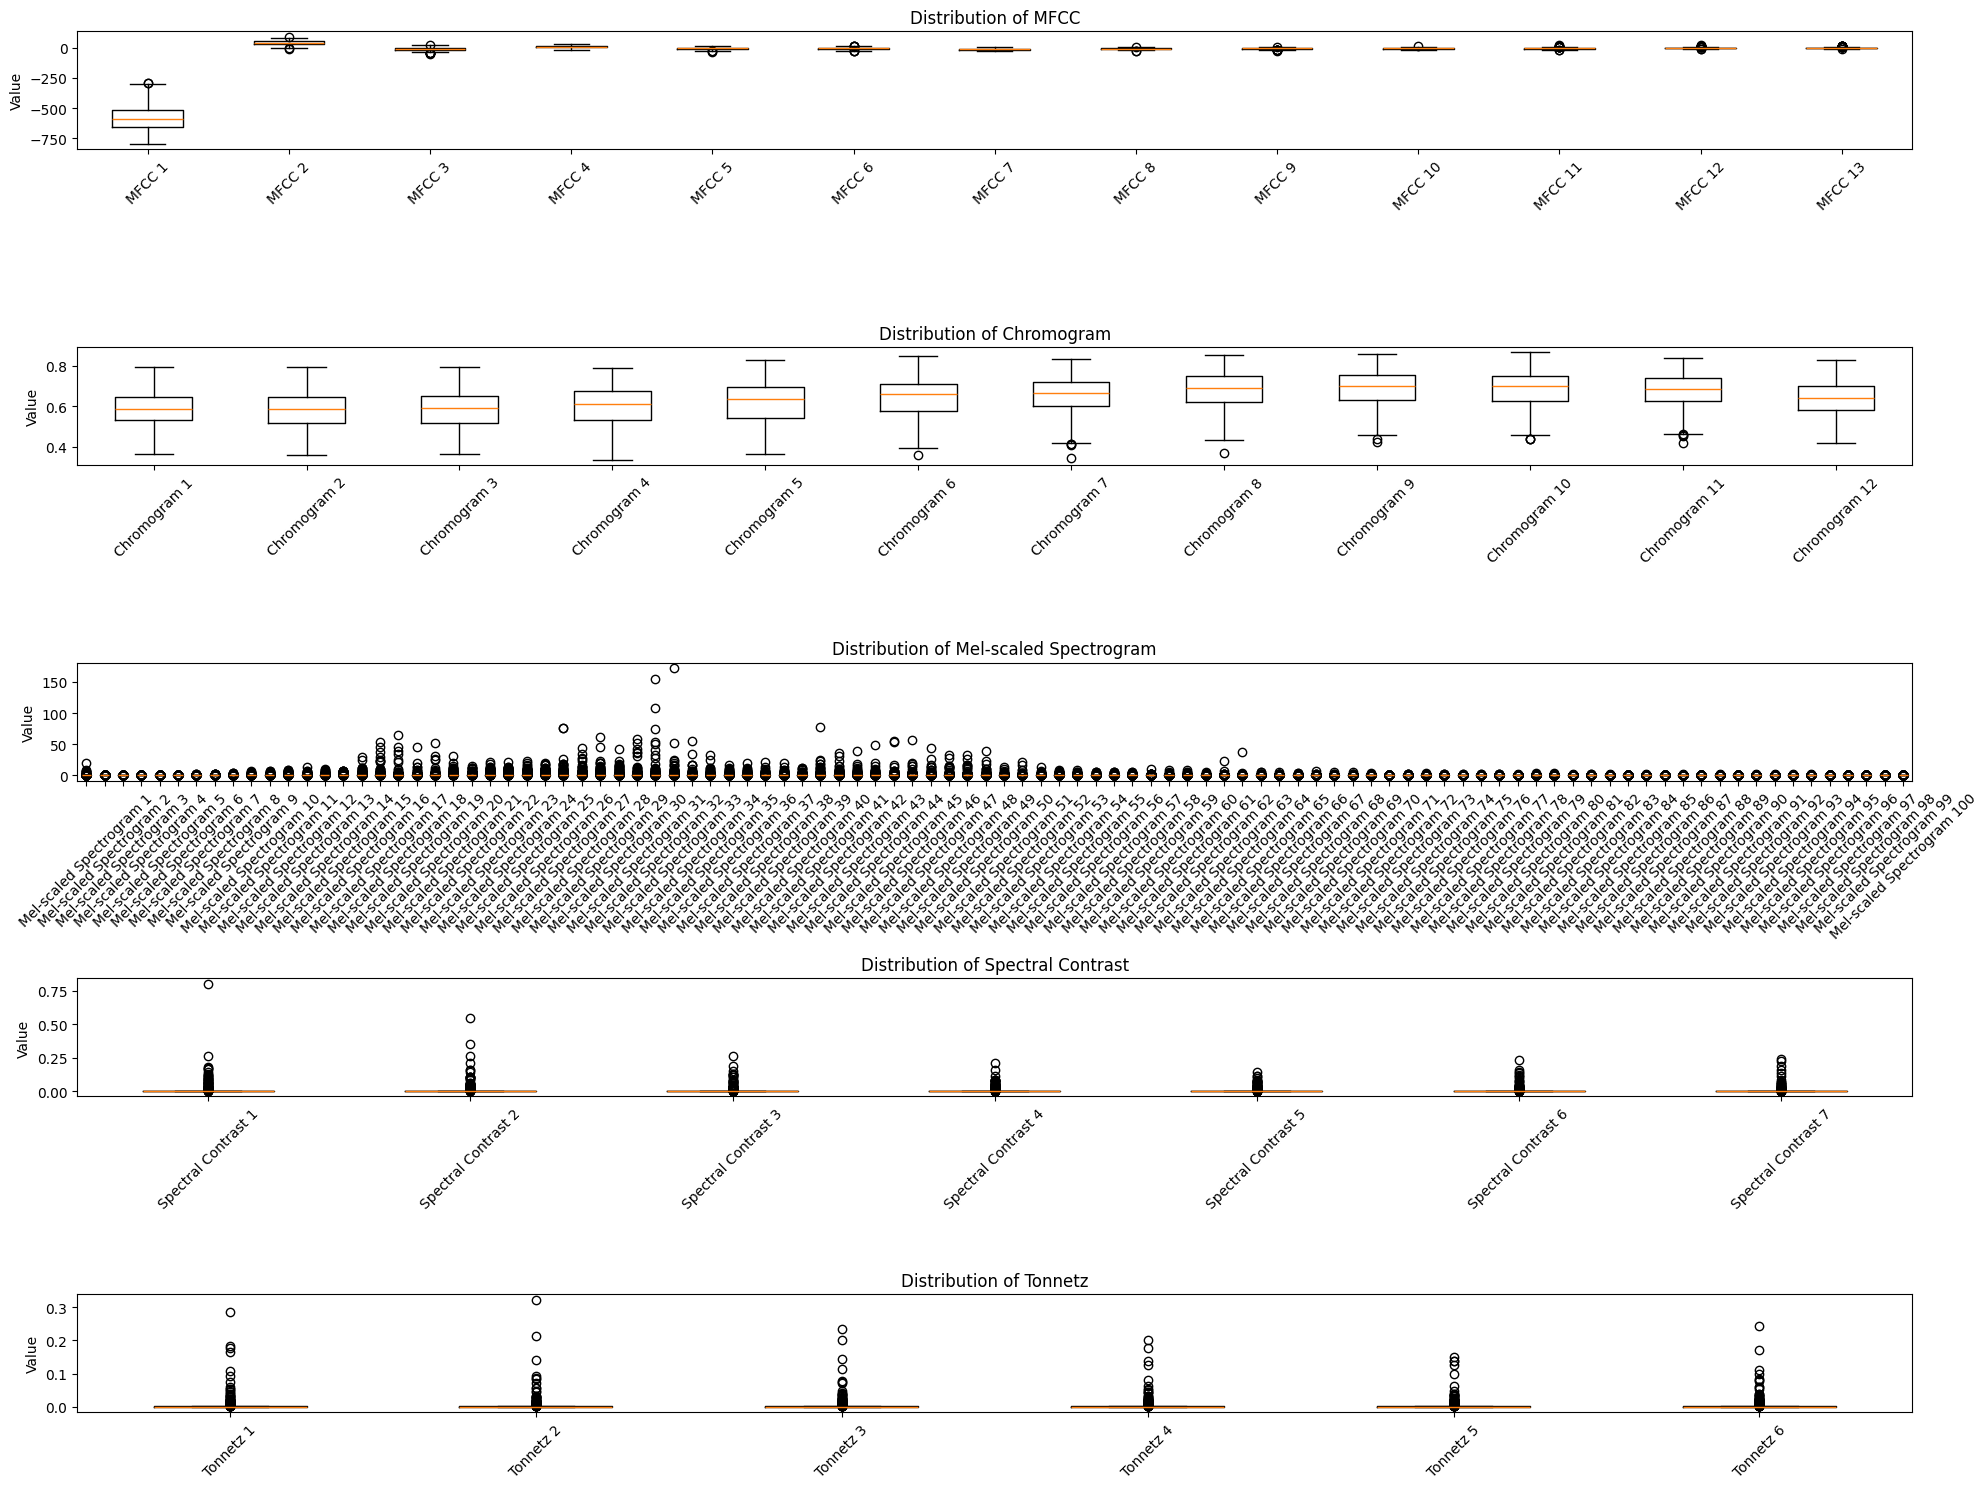

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your balanced dataset
balanced_df = pd.read_csv('speech_emotion_recognition_balanced.csv')

# Extract features
X = balanced_df.drop(columns=['label']).to_numpy()

# Define feature names and their dimensions
feature_names = {
    'MFCC': 13,
    'Chromogram': 12,
    'Mel-scaled Spectrogram': 100,
    'Spectral Contrast': 7,
    'Tonnetz': 6
}

# Initialize plot
plt.figure(figsize=(20, 15))

# Start plotting the features
start_idx = 0
for feature_name, feature_dim in feature_names.items():
    end_idx = start_idx + feature_dim
    
    # Plot the features for each feature type
    plt.subplot(len(feature_names), 1, list(feature_names.keys()).index(feature_name) + 1)
    plt.boxplot(X[:, start_idx:end_idx], labels=[f'{feature_name} {i+1}' for i in range(feature_dim)])
    plt.title(f'Distribution of {feature_name}')
    plt.ylabel('Value')
    plt.xticks(rotation=45)

    start_idx = end_idx

plt.tight_layout()
plt.show()


In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the balanced dataset
balanced_df = pd.read_csv('speech_emotion_recognition_balanced.csv')

# Separate features and labels
X = balanced_df.drop(columns=['label']).to_numpy()  # Features
y = balanced_df['label'].to_numpy()                 # Labels

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
y_encoded = label_encoder.fit_transform(y)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the features
X_standardized = scaler.fit_transform(X)

# Print the shapes and first few rows of the processed data
print(f"Shape of features after standardization: {X_standardized.shape}")
print(f"Shape of encoded labels: {y_encoded.shape}")
print(f"First 5 standardized feature vectors:\n{X_standardized[:5]}")
print(f"First 5 encoded labels: {y_encoded[:5]}")


Shape of features after standardization: (768, 166)
Shape of encoded labels: (768,)
First 5 standardized feature vectors:
[[-1.28611128 -0.12472755 -0.22607226 -0.9298732  -0.45868208 -0.12572181
  -1.12545723 -0.51305242 -0.84454026 -0.43789727 -1.46375834 -0.69539078
  -0.45687433 -1.69529425 -1.76062431 -2.01524451 -2.19757024 -2.01280115
  -1.34386264 -1.64482594 -1.53312921 -2.06220796 -2.34118672 -2.37403139
  -2.23127115 -0.12952039 -0.1030299  -0.33265343 -0.28349642 -0.44163179
  -0.36424751 -0.38366232 -0.34281835 -0.31085804 -0.36355651 -0.34737241
  -0.32314281 -0.30898885 -0.32297949 -0.31675862 -0.23388826 -0.19428146
  -0.15360069 -0.19062354 -0.19104607 -0.29275878 -0.33457794 -0.3188807
  -0.31392541 -0.28946706 -0.31029217 -0.18295285 -0.21452979 -0.22233423
  -0.2337872  -0.17523372 -0.14056804 -0.11484148 -0.15536947 -0.20265911
  -0.23176225 -0.20978375 -0.20168156 -0.20461991 -0.22856735 -0.14383765
  -0.18448053 -0.16924612 -0.15544972 -0.12852494 -0.14394863 -0.

In [10]:
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=0.01, solver='adam', random_state=42, verbose=False)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

target_names = [str(label) for label in label_encoder.classes_]

# Generate classification report
report = classification_report(y_test, y_pred, target_names=target_names)

# Print accuracy and classification report
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.4155844155844156
Classification Report:
              precision    recall  f1-score   support

           1       0.41      0.58      0.48        19
           2       0.50      0.58      0.54        19
           3       0.39      0.37      0.38        19
           4       0.30      0.30      0.30        20
           5       0.54      0.37      0.44        19
           6       0.41      0.47      0.44        19
           7       0.35      0.30      0.32        20
           8       0.47      0.37      0.41        19

    accuracy                           0.42       154
   macro avg       0.42      0.42      0.41       154
weighted avg       0.42      0.42      0.41       154



/home/shreya/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [11]:
## from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'hidden_layer_sizes': [(256,128,64), (512,256,128), (128,64,32)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant', 'adaptive'],
    'batch_size': [32,64,128],
    'max_iter': [200, 500,1000]
}

mlp=MLPClassifier(random_state=9)

random_search_model=RandomizedSearchCV(estimator=mlp, param_distributions=param_dist, n_iter=50, n_jobs=-1, cv=3, verbose=2, random_state=9)

random_search_model.fit(X_standardized, y_encoded)

print('Best parameters found: ', random_search_model.best_params_)
print('Best score found: ', random_search_model.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=(512, 256, 128), learning_rate=constant, max_iter=1000, solver=sgd; total time=   9.4s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=(512, 256, 128), learning_rate=constant, max_iter=1000, solver=sgd; total time=  11.2s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=(512, 256, 128), learning_rate=constant, max_iter=1000, solver=sgd; total time=  11.2s


/home/shreya/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, batch_size=128, hidden_layer_sizes=(128, 64, 32), learning_rate=adaptive, max_iter=500, solver=sgd; total time=  13.4s


/home/shreya/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, batch_size=128, hidden_layer_sizes=(128, 64, 32), learning_rate=adaptive, max_iter=500, solver=sgd; total time=  15.0s


/home/shreya/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, batch_size=128, hidden_layer_sizes=(128, 64, 32), learning_rate=adaptive, max_iter=500, solver=sgd; total time=  17.6s


/home/shreya/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, batch_size=64, hidden_layer_sizes=(128, 64, 32), learning_rate=constant, max_iter=500, solver=sgd; total time=  27.4s


/home/shreya/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, batch_size=64, hidden_layer_sizes=(128, 64, 32), learning_rate=constant, max_iter=500, solver=sgd; total time=  27.7s


/home/shreya/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, batch_size=64, hidden_layer_sizes=(128, 64, 32), learning_rate=constant, max_iter=500, solver=sgd; total time=  29.9s
[CV] END activation=relu, batch_size=128, hidden_layer_sizes=(256, 128, 64), learning_rate=adaptive, max_iter=1000, solver=adam; total time=  11.9s
[CV] END activation=relu, batch_size=128, hidden_layer_sizes=(256, 128, 64), learning_rate=adaptive, max_iter=1000, solver=adam; total time=  12.2s
[CV] END activation=relu, batch_size=128, hidden_layer_sizes=(256, 128, 64), learning_rate=adaptive, max_iter=1000, solver=adam; total time=  13.1s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=(128, 64, 32), learning_rate=adaptive, max_iter=1000, solver=sgd; total time=   5.7s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=(128, 64, 32), learning_rate=adaptive, max_iter=1000, solver=sgd; total time=   5.0s
[CV] END activation=logistic, batch_size=64, hidden_layer_sizes=(128, 64, 32), learning_rate=adaptive, max_iter=10

/home/shreya/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, batch_size=64, hidden_layer_sizes=(256, 128, 64), learning_rate=adaptive, max_iter=500, solver=sgd; total time= 1.2min


/home/shreya/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, batch_size=64, hidden_layer_sizes=(256, 128, 64), learning_rate=adaptive, max_iter=500, solver=sgd; total time= 1.2min


/home/shreya/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, batch_size=64, hidden_layer_sizes=(256, 128, 64), learning_rate=adaptive, max_iter=500, solver=sgd; total time= 1.3min
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=(512, 256, 128), learning_rate=adaptive, max_iter=1000, solver=sgd; total time=  28.7s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=(512, 256, 128), learning_rate=adaptive, max_iter=1000, solver=sgd; total time=  31.7s
[CV] END activation=logistic, batch_size=128, hidden_layer_sizes=(512, 256, 128), learning_rate=adaptive, max_iter=1000, solver=sgd; total time=  28.8s


KeyboardInterrupt: 

In [13]:
## prediction with basic model
import seaborn as sns
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=target_names, yticklabels=target_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_basic = mlp.predict(X_test)
accuracy_basic = accuracy_score(y_test, y_pred_basic)
report_basic = classification_report(y_test, y_pred_basic, target_names=target_names)
confusion_matrix_basic = confusion_matrix(y_test, y_pred_basic)
plot_confusion_matrix(confusion_matrix_basic, title="Confusion Matrix of Basic Model")


print(f"Accuracy of basic model: {accuracy_basic}")
print("Classification Report of basic model:")
print(report_basic)


NotFittedError: This MLPClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

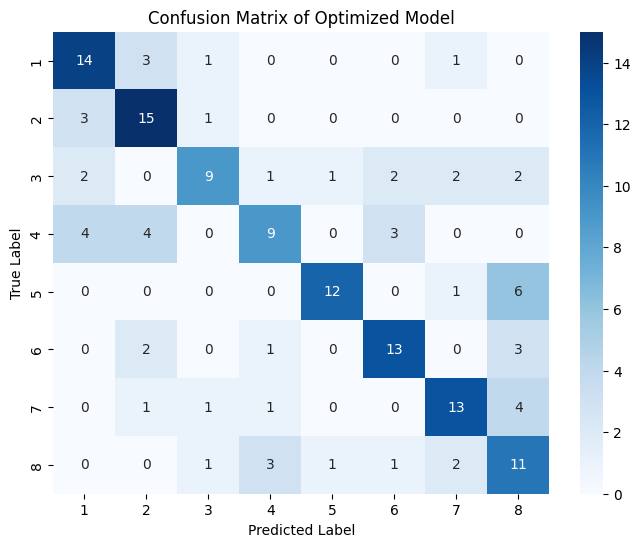

Accuracy of optimized model: 0.6233766233766234
Classification Report of optimized model:
              precision    recall  f1-score   support

           1       0.61      0.74      0.67        19
           2       0.60      0.79      0.68        19
           3       0.69      0.47      0.56        19
           4       0.60      0.45      0.51        20
           5       0.86      0.63      0.73        19
           6       0.68      0.68      0.68        19
           7       0.68      0.65      0.67        20
           8       0.42      0.58      0.49        19

    accuracy                           0.62       154
   macro avg       0.64      0.62      0.62       154
weighted avg       0.64      0.62      0.62       154



In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=target_names, yticklabels=target_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Assuming random_search_model has already been defined and fitted
optimized_mlp = random_search_model.best_estimator_

# Fit the optimized model to the training data
optimized_mlp.fit(X_train, y_train)

# Make predictions with optimized model
y_pred_optimized = optimized_mlp.predict(X_test)

# Calculate accuracy and classification report
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
report_optimized = classification_report(y_test, y_pred_optimized, target_names=target_names)

# Generate confusion matrix
confusion_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)

# Plot confusion matrix for the optimized model
plot_confusion_matrix(confusion_matrix_optimized, title="Confusion Matrix of Optimized Model")

# Print accuracy and classification report
print(f"Accuracy of optimized model: {accuracy_optimized}")
print("Classification Report of optimized model:")
print(report_optimized)


### Accuracy

Basic model - 0.616
Optimised model - 0.6234

### Precision

Basic model - 0.47 to 0.76
Optimised model - 0.53 to 0.82

### Recall

Basic model - 0.35 to 0.68
Optimised model - 0.45 to 0.74

### F1 Score

Optimised model - 0.40 to 0.72
Optimised model - 0.51 to 0.78

### Confusion Matrix

The optimized model has better diagonal values for classes 5 through 8. Misclassification rates between classes have decreased, especially for class 4, where the predictions are more accurate.

In [117]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=9)

random_search_model = RandomizedSearchCV(estimator=mlp, param_distributions=param_dist, n_iter=50, n_jobs=-1, cv=kf, verbose=2, random_state=9)
random_search_model.fit(X_standardized, y_encoded)

print('Best parameters found: ', random_search_model.best_params_)
print('Best score found: ', random_search_model.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reac

Best parameters found:  {'solver': 'adam', 'max_iter': 500, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (512, 256, 128), 'batch_size': 128, 'activation': 'relu'}
Best score found:  0.5195484254307784


Best parameters found:  {'solver': 'adam', 'max_iter': 500, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (512, 256, 128), 'batch_size': 128, 'activation': 'relu'}
Best score found:  0.5195484254307784

In [119]:
from sklearn.model_selection import cross_val_score

# Train and evaluate the optimized model
best_params = random_search_model.best_params_
optimized_model = MLPClassifier(**best_params, random_state=9)
optimized_model.fit(X_standardized, y_encoded)

# Evaluate the model using cross-validation
scores = cross_val_score(optimized_model, X_standardized, y_encoded, cv=kf, scoring='accuracy')
print(f"Cross-Validation Scores: {scores}")
print(f"Mean Accuracy: {np.mean(scores)}")
print(f"Standard Deviation: {np.std(scores)}")

Cross-Validation Scores: [0.52597403 0.52597403 0.58441558 0.47058824 0.55555556]
Mean Accuracy: 0.532501485442662
Standard Deviation: 0.03780219522495008


In [120]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report


# SVM Classifier
svm = SVC(kernel='rbf', gamma='scale', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_report = classification_report(y_test, y_pred_svm)

# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_report = classification_report(y_test, y_pred_knn)

print("\n--- SVM Classifier ---")
print("Accuracy: ", svm_accuracy)
print("Classification Report:\n", svm_report)

print("\n--- KNN Classifier ---")
print("Accuracy: ", knn_accuracy)
print("Classification Report:\n", knn_report)


--- SVM Classifier ---
Accuracy:  0.42857142857142855
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.74      0.43        19
           1       0.41      0.37      0.39        19
           2       0.47      0.42      0.44        19
           3       0.40      0.20      0.27        20
           4       0.70      0.37      0.48        19
           5       0.57      0.21      0.31        19
           6       0.60      0.45      0.51        20
           7       0.41      0.68      0.51        19

    accuracy                           0.43       154
   macro avg       0.48      0.43      0.42       154
weighted avg       0.48      0.43      0.42       154


--- KNN Classifier ---
Accuracy:  0.37662337662337664
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.68      0.39        19
           1       0.50      0.37      0.42        19
           2       0.39     

###### SVM and KNN perform worser than  MLP. Hence, we should stick with MLP for this dataset.